# TODO  
## Card Similarity Search  
### Data Prep (raw card data > clean card data) 
  - ~~merge card, set, and legality data~~  
  - ~~concat token cards (later - may not want to)~~  
  - ensure clean  
    - fillna, non-english issues, maybe replace symbols ({T}...) w/ text  
  - **AWS**  
    - ~~Load raw MTGJson from S3~~  
    - ~~Lambda (or Glue): Prep > to S3~~  
### Similarity (clean card data > embeddings, similarity matrix)
  - ~~USE embeddings from card text~~  
  - ~~explore including other card props as text (color, type, mana cost...)~~  
  - ~~similarity matrix~~  
  - ~~pre-sort and save each card (50K+ cards)~~  
  - STILL NEED TO ADD SCRYFALL IMAGE URLs TO DATA PREP PIPELINE
  - **AWS**  
    - ~~Load clean card data from S3~~  
    - ~~SM Processing Job: USE embeddings & similarity matrix > to S3~~  
    - ~~Lambda: embeddings/sim_matrix from S3 > EFS~~  
    - ~~Lambda: sort each card by similarity EFS > EFS & DynamoDB~~
### App Backend  
  - API accepts card name and returns topK similar cards (w/ some metadata for filtering)  
  - **AWS**  
    - Lambda: API queries EFS or Dynamo  
    - StepFunctions or Lambda destinations: refresh data pipeline as needed
### App Frontend  
  - Home page  
    - Search box and results  
    - A few filters (color, type, mana cost...)  
    - add placement  
    - sign in (eventually)  
### Deploy  
  - Backend
    - Serverless  
    - Seed  
  - Frontend  
    - React  
    - Amplify

# Data Prep

In [1]:
import os
import json
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

In [53]:
cards_df = pd.read_csv('../data/mtgjson/cards.csv')\
    .drop(columns=['index'])

print(cards_df.shape)
print('{} MB'.format(round(cards_df.memory_usage().sum()/1000000, 2)))
cards_df.head(1)

(56490, 74)
33.44 MB


,id,artist,asciiName,availability,borderColor,cardKingdomFoilId,cardKingdomId,colorIdentity,colorIndicator,colors,...,subtypes,supertypes,tcgplayerProductId,text,toughness,type,types,uuid,variations,watermark
0,1,Pete Venters,NaN,"mtgo,paper",black,NaN,122719.0,W,NaN,W,...,"Human,Cleric",NaN,15032.0,First strike (This creature deals combat damag...,4,Creature — Human Cleric,Creature,5f8287b1-5bb6-5f4c-ad17-316a40d5bb0c,b7c19924-b4bf-56fc-aa73-f586e940bd42,NaN


In [54]:
sets_df = pd.read_csv('../data/mtgjson/sets.csv')[['code','name']]\
    .rename(columns={'name': 'setName', 'code':'setCode'})

print(sets_df.shape)
print('{} MB'.format(round(sets_df.memory_usage().sum()/1000000, 2)))
sets_df.head(1)

(549, 2)
0.01 MB


,setCode,setName
0,10E,Tenth Edition


In [55]:
# Merge set names into cards
cards_df = cards_df\
    .merge(sets_df, how='left', on='setCode')

print(cards_df.shape)
print('{} MB'.format(round(cards_df.memory_usage().sum()/1000000, 2)))
cards_df.head(1)

(56490, 75)
34.35 MB


,id,artist,asciiName,availability,borderColor,cardKingdomFoilId,cardKingdomId,colorIdentity,colorIndicator,colors,...,supertypes,tcgplayerProductId,text,toughness,type,types,uuid,variations,watermark,setName
0,1,Pete Venters,NaN,"mtgo,paper",black,NaN,122719.0,W,NaN,W,...,NaN,15032.0,First strike (This creature deals combat damag...,4,Creature — Human Cleric,Creature,5f8287b1-5bb6-5f4c-ad17-316a40d5bb0c,b7c19924-b4bf-56fc-aa73-f586e940bd42,NaN,Tenth Edition


In [56]:
legs_df = pd.read_csv('../data/mtgjson/legalities.csv')\
    .pivot(index='uuid', columns='format', values='status')\
    .reset_index()\
    .fillna('Blank')

print(legs_df.shape)
print('{} MB'.format(round(legs_df.memory_usage().sum()/1000000, 2)))
legs_df.head(1)

(55250, 16)
7.07 MB


format,uuid,brawl,commander,duel,future,gladiator,historic,legacy,modern,oldschool,pauper,penny,pioneer,premodern,standard,vintage
0,00010d56-fe38-5e35-8aed-518019aa36a5,Blank,Legal,Legal,Blank,Blank,Blank,Legal,Legal,Blank,Blank,Blank,Legal,Blank,Blank,Legal


In [57]:
# Merge legalities into cards
cards_df = cards_df\
    .merge(legs_df, how='left', on='uuid')

print(cards_df.shape)
print('{} MB'.format(round(cards_df.memory_usage().sum()/1000000, 2)))
cards_df.head(1)

(56490, 90)
41.12 MB


,id,artist,asciiName,availability,borderColor,cardKingdomFoilId,cardKingdomId,colorIdentity,colorIndicator,colors,...,historic,legacy,modern,oldschool,pauper,penny,pioneer,premodern,standard,vintage
0,1,Pete Venters,NaN,"mtgo,paper",black,NaN,122719.0,W,NaN,W,...,Blank,Legal,Legal,Blank,Blank,Legal,Blank,Legal,Blank,Legal


In [58]:
def get_image_uris(row):
    try:
        if pd.notna(row['image_uris']):
            return row['image_uris']
        else:
            return [card['image_uris'] for card in row['card_faces']]
    except:
        return 'Blank'

In [59]:
scryfall_df.shape

(8077, 2)

In [14]:
scryfall_df.name.nunique()

22313

In [18]:
scryfall_df.query('arena_id.notnull() and booster').shape

(4638, 77)

In [5]:
scryfall_df = pd.read_json('../data/scryfall/cards.json')
print(scryfall_df.columns)
scryfall_df.head(2)

Index(['object', 'id', 'oracle_id', 'multiverse_ids', 'mtgo_id',
       'mtgo_foil_id', 'tcgplayer_id', 'cardmarket_id', 'name', 'lang',
       'released_at', 'uri', 'scryfall_uri', 'layout', 'highres_image',
       'image_uris', 'mana_cost', 'cmc', 'type_line', 'oracle_text', 'power',
       'toughness', 'colors', 'color_identity', 'keywords', 'legalities',
       'games', 'reserved', 'foil', 'nonfoil', 'oversized', 'promo', 'reprint',
       'variation', 'set', 'set_name', 'set_type', 'set_uri', 'set_search_uri',
       'scryfall_set_uri', 'rulings_uri', 'prints_search_uri',
       'collector_number', 'digital', 'rarity', 'flavor_text', 'card_back_id',
       'artist', 'artist_ids', 'illustration_id', 'border_color', 'frame',
       'full_art', 'textless', 'booster', 'story_spotlight', 'edhrec_rank',
       'prices', 'related_uris', 'all_parts', 'promo_types', 'arena_id',
       'preview', 'produced_mana', 'watermark', 'frame_effects',
       'printed_name', 'card_faces', 'loyalty', 

,object,id,oracle_id,multiverse_ids,mtgo_id,mtgo_foil_id,tcgplayer_id,cardmarket_id,name,lang,...,card_faces,loyalty,color_indicator,life_modifier,hand_modifier,printed_type_line,printed_text,content_warning,variation_of,flavor_name
0,card,0000579f-7b35-4ed3-b44c-db2a538066fe,44623693-51d6-49ad-8cd7-140505caf02f,[109722],25527.0,25528.0,14240.0,13850.0,Fury Sliver,en,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,card,00006596-1166-4a79-8443-ca9f82e6db4e,8ae3562f-28b7-4462-96ed-be0cf7052ccc,[189637],34586.0,34587.0,33347.0,21851.0,Kor Outfitter,en,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
scryfall_df.query('name == "Kaya the Inexorable" or name=="Banishing Light"')\
    [['set_name','name','arena_id','released_at']]

,set_name,name,arena_id,released_at
5087,Kaldheim,Kaya the Inexorable,NaN,2021-02-05
12172,Kaldheim,Kaya the Inexorable,NaN,2021-02-05
33773,Commander 2015,Banishing Light,NaN,2015-11-13
36208,Theros Beyond Death,Banishing Light,70515.0,2020-01-24
44786,Friday Night Magic 2014,Banishing Light,NaN,2014-01-01
45338,Jumpstart Arena Exclusives,Banishing Light,74986.0,2020-07-17
47500,Zendikar Rising Commander,Banishing Light,NaN,2020-09-25
51335,Commander Anthology Volume II,Banishing Light,NaN,2018-06-08
52103,Magic Online Promos,Banishing Light,NaN,2014-10-22
56413,Journey into Nyx,Banishing Light,NaN,2014-05-02


In [6]:
supported_sets = [
  'Throne of Eldraine',
  'Theros Beyond Death',
  'Ikoria: Lair of Behemoths',
  'Core Set 2021',
  'Zendikar Rising',
  'Kaldheim',
  'Core Set 2020',
  'War of the Spark',
  'Ravnica Allegiance',
  'Guilds of Ravnica',
  'Ixalan',
  'Rivals of Ixalan',
  'Dominaria',
  'Core Set 2019',
  'Historic Anthology',
  'Historic Anthology 2',
  'Historic Anthology 3',
  'Jumpstart',
  'Amonkhet Remastered',
  'Kaladesh Remastered'
]

In [7]:
scryfall_df = pd.read_json('../data/scryfall/cards.json')

In [8]:
scryfall_sets = scryfall_df.set_name.unique()

In [9]:
supported_sets_varients = [scry_s for scry_s in scryfall_sets if any([s in scry_s for s in supported_sets])]

In [10]:
supported_sets_varients

['Ixalan',
 'Throne of Eldraine',
 'Core Set 2021',
 'Jumpstart',
 'Guilds of Ravnica',
 'Dominaria',
 'Core Set 2019',
 'Zendikar Rising Art Series',
 'Ravnica Allegiance',
 'Kaldheim Commander',
 'Zendikar Rising Commander',
 'Ikoria: Lair of Behemoths Promos',
 'Core Set 2019 Promos',
 'Zendikar Rising Promos',
 'Core Set 2021 Promos',
 'Amonkhet Remastered',
 'Kaldheim Promos',
 'Theros Beyond Death Promos',
 'War of the Spark Promos',
 'Zendikar Rising',
 'Dominaria Promos',
 'Ikoria: Lair of Behemoths',
 'Explorers of Ixalan',
 'War of the Spark',
 'Rivals of Ixalan',
 'Zendikar Rising Expeditions',
 'Kaladesh Remastered',
 'Core Set 2020',
 'Theros Beyond Death',
 'Kaldheim Commander Tokens',
 'Throne of Eldraine Promos',
 'Zendikar Rising Commander Tokens',
 'Ravnica Allegiance Tokens',
 'Historic Anthology 3',
 'Kaldheim Tokens',
 'Ravnica Allegiance Promos',
 'Kaldheim',
 'Core Set 2020 Promos',
 'Guilds of Ravnica Tokens',
 'Guilds of Ravnica Promos',
 'Historic Anthology 4'

In [65]:
# Scryfall image urls
scryfall_df = scryfall_df\
    .query('set_name == @supported_sets_varients')\
    [['id','image_uris','card_faces']]\
    .reset_index(drop=True)\
    .assign(image_urls=lambda df: df.apply(get_image_uris, axis=1))\
    .drop(columns=['image_uris','card_faces'])\
    .rename(columns={'id': 'scryfallId'})

print(scryfall_df.shape)
print('{} MB'.format(round(scryfall_df.memory_usage().sum()/1000000, 2)))
scryfall_df.head(3)

(8077, 2)
0.13 MB


,scryfallId,image_urls
0,0000cd57-91fe-411f-b798-646e965eec37,{'small': 'https://c1.scryfall.com/file/scryfa...
1,0001f1ef-b957-4a55-b47f-14839cdbab6f,{'small': 'https://c1.scryfall.com/file/scryfa...
2,0002ab72-834b-4c81-82b1-0d2760ea96b0,{'small': 'https://c1.scryfall.com/file/scryfa...


In [67]:
cards_df = cards_df\
    .merge(scryfall_df, how='left', on='scryfallId')

print(cards_df.shape)
print('{} MB'.format(round(cards_df.memory_usage().sum()/1000000, 2)))
cards_df.head(1)

(56490, 91)
41.58 MB


,id,artist,asciiName,availability,borderColor,cardKingdomFoilId,cardKingdomId,colorIdentity,colorIndicator,colors,...,legacy,modern,oldschool,pauper,penny,pioneer,premodern,standard,vintage,image_urls
0,1,Pete Venters,NaN,"mtgo,paper",black,NaN,122719.0,W,NaN,W,...,Legal,Legal,Blank,Blank,Legal,Blank,Legal,Blank,Legal,NaN


In [68]:
cards_df.to_csv('cards.csv', index=False)

In [2]:
cards_df = pd.read_csv('cards.csv')

C:\Users\lwest\Anaconda3\envs\magicml\lib\site-packages\IPython\core\interactiveshell.py:3147: DtypeWarning: Columns (11,15,18,39,50,90) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
cards_df.head(2)

,id,artist,asciiName,availability,borderColor,cardKingdomFoilId,cardKingdomId,colorIdentity,colorIndicator,colors,...,legacy,modern,oldschool,pauper,penny,pioneer,premodern,standard,vintage,image_urls
0,1,Pete Venters,NaN,"mtgo,paper",black,NaN,122719.0,W,NaN,W,...,Legal,Legal,Blank,Blank,Legal,Blank,Legal,Blank,Legal,NaN
1,2,Volkan Baǵa,NaN,"mtgo,paper",black,NaN,122720.0,W,NaN,W,...,Legal,Legal,Blank,Legal,Legal,Blank,Legal,Blank,Legal,NaN


In [4]:
cards_df.shape

(56490, 91)

In [5]:
cards_df.columns

Index(['id', 'artist', 'asciiName', 'availability', 'borderColor',
       'cardKingdomFoilId', 'cardKingdomId', 'colorIdentity', 'colorIndicator',
       'colors', 'convertedManaCost', 'duelDeck', 'edhrecRank',
       'faceConvertedManaCost', 'faceName', 'flavorName', 'flavorText',
       'frameEffects', 'frameVersion', 'hand', 'hasAlternativeDeckLimit',
       'hasContentWarning', 'hasFoil', 'hasNonFoil', 'isAlternative',
       'isFullArt', 'isOnlineOnly', 'isOversized', 'isPromo', 'isReprint',
       'isReserved', 'isStarter', 'isStorySpotlight', 'isTextless',
       'isTimeshifted', 'keywords', 'layout', 'leadershipSkills', 'life',
       'loyalty', 'manaCost', 'mcmId', 'mcmMetaId', 'mtgArenaId',
       'mtgjsonV4Id', 'mtgoFoilId', 'mtgoId', 'multiverseId', 'name', 'number',
       'originalReleaseDate', 'originalText', 'originalType', 'otherFaceIds',
       'power', 'printings', 'promoTypes', 'purchaseUrls', 'rarity',
       'scryfallId', 'scryfallIllustrationId', 'scryfallOracleI

In [43]:
[s for s in cards_df.setName.unique() if "Kaldheim" in s]

['Kaldheim Commander', 'Kaldheim']

In [11]:
cards_df[['mtgArenaId','scryfallId','setName']].query('setName == @supported_sets_varients').shape

(7998, 3)

In [ ]:
cards_df

In [12]:
arena_df = cards_df.query('setName == @supported_sets_varients')\
    .reset_index(drop=True)\
    .fillna(value={'text': 'Blank'})

print(arena_df.shape)

(7998, 91)


In [13]:
arena_df.columns

Index(['id', 'artist', 'asciiName', 'availability', 'borderColor',
       'cardKingdomFoilId', 'cardKingdomId', 'colorIdentity', 'colorIndicator',
       'colors', 'convertedManaCost', 'duelDeck', 'edhrecRank',
       'faceConvertedManaCost', 'faceName', 'flavorName', 'flavorText',
       'frameEffects', 'frameVersion', 'hand', 'hasAlternativeDeckLimit',
       'hasContentWarning', 'hasFoil', 'hasNonFoil', 'isAlternative',
       'isFullArt', 'isOnlineOnly', 'isOversized', 'isPromo', 'isReprint',
       'isReserved', 'isStarter', 'isStorySpotlight', 'isTextless',
       'isTimeshifted', 'keywords', 'layout', 'leadershipSkills', 'life',
       'loyalty', 'manaCost', 'mcmId', 'mcmMetaId', 'mtgArenaId',
       'mtgjsonV4Id', 'mtgoFoilId', 'mtgoId', 'multiverseId', 'name', 'number',
       'originalReleaseDate', 'originalText', 'originalType', 'otherFaceIds',
       'power', 'printings', 'promoTypes', 'purchaseUrls', 'rarity',
       'scryfallId', 'scryfallIllustrationId', 'scryfallOracleI

In [76]:
arena_df.query('name == "Kaya the Inexorable"').image_urls

2651    {'small': 'https://c1.scryfall.com/file/scryfa...
2726    {'small': 'https://c1.scryfall.com/file/scryfa...
Name: image_urls, dtype: object


### Handle token cards later

In [53]:
tokens_df = pd.read_csv('../data/mtgjson/tokens.csv')

print(tokens_df.shape)
print('{} MB'.format(round(tokens_df.memory_usage().sum()/1000000, 2)))
tokens_df.head(1)

(1704, 45)
0.61 MB


,index,id,artist,asciiName,availability,borderColor,colorIdentity,colors,edhrecRank,faceName,...,side,subtypes,supertypes,tcgplayerProductId,text,toughness,type,types,uuid,watermark
0,0,1,Jim Pavelec,NaN,paper,black,R,R,NaN,NaN,...,NaN,Dragon,NaN,78608.0,Flying,5,Token Creature — Dragon,"Token,Creature",7decf258-eb10-50da-83f7-c7eba74adbfb,NaN


In [3]:
print(cards_df.shape)
cards_df.head(2)

(55943, 74)


,id,artist,asciiName,availability,borderColor,cardKingdomFoilId,cardKingdomId,colorIdentity,colorIndicator,colors,...,subtypes,supertypes,tcgplayerProductId,text,toughness,type,types,uuid,variations,watermark
0,1,Rebecca Guay,NaN,"mtgo,paper",black,123335.0,122967.0,G,NaN,G,...,NaN,NaN,15023.0,"If you would draw a card, you may instead choo...",NaN,Enchantment,Enchantment,38513fa0-ea83-5642-8ecd-4f0b3daa6768,NaN,NaN
1,2,Stephen Daniele,NaN,"mtgo,paper",black,123149.0,122781.0,U,NaN,U,...,"Human,Wizard",NaN,15024.0,When Academy Researchers enters the battlefiel...,2,Creature — Human Wizard,Creature,b8a68840-4044-52c0-a14e-0a1c630ba42c,NaN,NaN


In [47]:
cards_df.type.nunique()

2022

In [48]:
cards_df.setCode.nunique()

534

In [9]:
cards_df.memory_usage().sum()/1000000

33.118384

In [56]:
for col in cards_df.columns:
    print(col + ': ' + str(cards_df[col][0]) + '\n')

id: 1

artist: Rebecca Guay

asciiName: nan

availability: mtgo,paper

borderColor: black

cardKingdomFoilId: 123335.0

cardKingdomId: 122967.0

colorIdentity: G

colorIndicator: nan

colors: G

convertedManaCost: 4.0

duelDeck: nan

edhrecRank: 1111.0

faceConvertedManaCost: nan

faceName: nan

flavorName: nan

flavorText: nan

frameEffects: nan

frameVersion: 2003

hand: nan

hasAlternativeDeckLimit: 0


hasFoil: 1

hasNonFoil: 1

isAlternative: 0

isFullArt: 0

isOnlineOnly: 0

isOversized: 0

isPromo: 0

isReprint: 1

isReserved: 0

isStarter: 0

isStorySpotlight: 0

isTextless: 0

isTimeshifted: 0

keywords: nan

layout: normal

leadershipSkills: nan

life: nan

loyalty: nan

manaCost: {2}{G}{G}

mcmId: 16413.0

mcmMetaId: 19.0

mtgArenaId: nan

mtgjsonV4Id: 1669af17-d287-5094-b005-4b143441442f

mtgoFoilId: 27283.0

mtgoId: 27282.0

multiverseId: 130483.0

name: Abundance

number: 249

originalReleaseDate: nan

originalText: If you would draw a card, you may instead choose land or

# Download and Store USE Model from TFHub

In [5]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-large/5'
model = hub.load(module_url)
print ("module %s loaded" % module_url)

module https://tfhub.dev/google/universal-sentence-encoder-large/5 loaded


## Saved the downloaded USE-Large model

In [2]:
tf.saved_model.save(model, "../models/use-large")

NameError: name 'model' is not defined

## Load USE-Large from local disk

In [2]:
import tensorflow as tf

In [3]:
use_embed = tf.saved_model.load('../models/use-large/1')

In [27]:
for local_path in model_files:
    s3_key = '/'.join(str(local_path).split('\\')[2:])
    if '.' in s3_key:
        s3.upload_file(str(local_path), 'magicml-models.dev', s3_key)

***
# Get USE Embeddings

In [70]:
corr = np.inner(embeddings, embeddings)
print(corr.shape)

(5, 5)


In [72]:
import plotly.express as px

In [73]:
card_df = pd.DataFrame(corr, columns=arena_name, index=arena_name)
card_df.head()

NameError: name 'arena_name' is not defined

In [107]:
test_card = 'Golos,_Tireless_Pilgrim'
test_card

'Golos,_Tireless_Pilgrim'

In [106]:
[card for card in card_df.columns if card.startswith('Golos')]

['Golos,_Tireless_Pilgrim']

In [108]:
card_df[[test_card]].sort_values(by=test_card, ascending=False)

,"Golos,_Tireless_Pilgrim"
3059,1.000000
1687,0.805584
1583,0.801413
2606,0.798853
835,0.796900
...,...
5170,-0.020036
3215,-0.020036
5212,-0.041830
4441,-0.041830


In [109]:
test_card = test_card.replace('_',' ')
arena_df.query('name == @test_card').text.values

array(['When Golos, Tireless Pilgrim enters the battlefield, you may search your library for a land card, put that card onto the battlefield tapped, then shuffle your library.\n{2}{W}{U}{B}{R}{G}: Exile the top three cards of your library. You may play them this turn without paying their mana costs.'],
      dtype=object)

In [112]:
test_name = arena_name[1583].replace('_',' ')
test_name

'Emergent Ultimatum'

In [113]:
arena_df.query('name == @test_name').text.values

array(['Search your library for up to three monocolored cards with different names and exile them. An opponent chooses one of those cards. Shuffle that card into your library. You may cast the other cards without paying their mana costs. Exile Emergent Ultimatum.'],
      dtype=object)

# Sagemaker Processing Workflow

In [1]:
import os
import pathlib
import boto3
from boto3.session import Session

def aws_connect(service, profile='default', session=False):
    # Connect to AWS with IAM Role
    sess = Session(profile_name=profile)

    try:
        resource = sess.resource(service)
        client = resource.meta.client

        if session:
            return resource, client, sess
        else:
            return resource, client
    except:
        client = sess.client(service)

        if session:
            return client, sess
        else:
            return client

In [2]:
_, s3, boto_sess = aws_connect('s3', 'lw2134', session=True)

In [ ]:
# Tar the model.tar.gz package
# from models/use-large directory
'tar -czvf model.tar.gz 1'

In [40]:
## SM Processing Job

In [33]:
import os
import boto3
#import sagemaker
#from sagemaker.processing import ScriptProcessor, ProcessingInput, ProcessingOutput

In [352]:
_, s3, boto_sess = aws_connect('s3', 'lw2134', session=True)
sm_client = boto_sess.client('sagemaker')

NameError: name 'aws_connect' is not defined

In [21]:
#sagemaker_session = sagemaker.Session(boto_session=boto_sess)
role = 'arn:aws:iam::553371509391:role/magicml-sagemaker'
image_uri = '763104351884.dkr.ecr.us-east-1.amazonaws.com/tensorflow-training:2.3.1-cpu-py37-ubuntu18.04'

model_bucket = 'magicml-models.dev'
model_prefix = 'use-large'
model_data = 's3://{}/{}/model.tar.gz'.format(model_bucket, model_prefix)

input_bucket = 'magicml-clean-data.dev'
input_prefix = 'cards'
input_data = 's3://{}/{}/cards.csv'.format(input_bucket, input_prefix)

src_bucket = 'magicml-src.dev'
src_prefix = 'sm_processing'
src_code = 's3://{}/{}/process_embeddings.py'.format(src_bucket, src_prefix)

output_bucket = 'magicml-inference.dev'
output_prefix = 'use-large'
output_data = 's3://{}/{}'.format(output_bucket, output_prefix)

In [18]:
s3.upload_file('../services/similarity/src/process_embeddings.py', 'magicml-src.dev', 'sm_processing/process_embeddings.py')

In [24]:
import datetime

In [30]:
now = datetime.datetime.now().strftime(format='%Y-%d-%m-%H-%M-%S')
now

'2020-25-12-01-48-25'

In [31]:
sm_client.create_processing_job(
    ProcessingJobName='use-large-embeddings-{}'.format(now),
    RoleArn=role,
    StoppingCondition={
        'MaxRuntimeInSeconds': 7200
    },
    AppSpecification={
        'ImageUri': image_uri,
        'ContainerEntrypoint': [
            'python3',
            '-v',
            '/opt/ml/processing/input/code/process_embeddings.py'
        ]
    },
    ProcessingResources={
        'ClusterConfig': {
            'InstanceCount': 1,
            'InstanceType': 'ml.m5.2xlarge',
            'VolumeSizeInGB': 30
        }
    },
    ProcessingInputs=[
        {
            'InputName': 'model',
            'S3Input': {
                'S3Uri': model_data,
                'LocalPath': '/opt/ml/processing/model',
                'S3DataType': 'S3Prefix',
                'S3InputMode': 'File',
                'S3DataDistributionType': 'FullyReplicated'
            }
        },
        {
            'InputName': 'cards',
            'S3Input': {
                'S3Uri': input_data,
                'LocalPath': '/opt/ml/processing/input',
                'S3DataType': 'S3Prefix',
                'S3InputMode': 'File',
                'S3DataDistributionType': 'FullyReplicated',
            }
        },
        {
            'InputName': 'code',
            'S3Input': {
                'S3Uri': src_code,
                'LocalPath': '/opt/ml/processing/input/code',
                'S3DataType': 'S3Prefix',
                'S3InputMode': 'File',
                'S3DataDistributionType': 'FullyReplicated'
            }
        }
    ],
    ProcessingOutputConfig={
        'Outputs': [
            {
                'OutputName': 'embeddings',
                'S3Output': {
                    'S3Uri': output_data,
                    'LocalPath': '/opt/ml/processing/output',
                    'S3UploadMode': 'EndOfJob'
                }
            }
        ]
    }
)

{'ProcessingJobArn': 'arn:aws:sagemaker:us-east-1:553371509391:processing-job/use-large-embeddings-2020-25-12-01-48-25',
 'ResponseMetadata': {'RequestId': 'd6479411-03f0-4e78-b0ff-b5575e855867',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'd6479411-03f0-4e78-b0ff-b5575e855867',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '119',
   'date': 'Fri, 25 Dec 2020 06:48:13 GMT'},
  'RetryAttempts': 0}}

# Free Text Search Lambda - Get Embedding, Sort, Merge, and Return (maybe cache in Dynamo)

In [2]:
from boto3.session import Session

def aws_connect(service, profile='default', session=False):
    # Connect to AWS with IAM Role
    sess = Session(profile_name=profile)

    try:
        resource = sess.resource(service)
        client = resource.meta.client

        if session:
            return resource, client, sess
        else:
            return resource, client
    except:
        client = sess.client(service)

        if session:
            return client, sess
        else:
            return client

In [3]:
import os
import json
import pathlib
import tarfile
import boto3
import numpy as np
import pandas as pd
import tensorflow as tf

In [6]:
_, s3, boto_sess = aws_connect('s3', 'lw2134', session=True)

In [7]:
# Cards
s3.download_file('magicml-clean-data.prod', 'cards/cards.csv', 'cardsS3.csv')

In [4]:
# Embeddings
s3.download_file('magicml-inference.prod', 'use-large/arena_embeddings.csv', 'embeddings.csv')

In [5]:
# Load Model
use_embed = tf.saved_model.load('../services/models/use-large/1')

In [14]:
merge_cols = [
    'Names','id','mtgArenaId','scryfallId','name','colors','setName',
    'convertedManaCost','manaCost','loyalty','power','toughness',
    'type','types','subtypes','text','image_urls',
    'brawl','commander','duel','future','historic','legacy','modern',
    'oldschool','pauper','penny','pioneer','standard','vintage'
  ]

In [15]:
# Get all embeddings
cards_df = pd.read_csv('cardsS3.csv')\
    .assign(Names=lambda df: df.name + '-' + df.id.astype('str'))\
    .assign(Names=lambda df: df.Names.apply(lambda x: x.replace(' ', '_').replace('//', 'II')))\
    .fillna('0')\
    [merge_cols]

cards_txt = list(cards_df.text)
cards_name = [
(name + '-' + str(id_val)).replace(' ','_').replace('//', 'II') for name, id_val in zip(cards_df.name, cards_df.id)
]

cards_df.head(2)

,Names,id,mtgArenaId,scryfallId,name,colors,setName,convertedManaCost,manaCost,loyalty,...,future,historic,legacy,modern,oldschool,pauper,penny,pioneer,standard,vintage
0,Archon_of_Sun's_Grace-4754,4754,74983,94f05268-0d4f-4638-aec3-a85fc339e3a7,Archon of Sun's Grace,W,Jumpstart Arena Exclusives,4.0,{2}{W}{W},0,...,Legal,Legal,Legal,Legal,Blank,Blank,Blank,Legal,Legal,Legal
1,Banishing_Light-4755,4755,74986,ca112bae-6ac5-4cdf-9e8c-1b99f7396995,Banishing Light,W,Jumpstart Arena Exclusives,3.0,{2}{W},0,...,Legal,Legal,Legal,Legal,Blank,Blank,Legal,Legal,Legal,Legal


In [23]:
cards_df[['Names','colors','type','types','subtypes']].sample(10)

,Names,colors,type,types,subtypes
734,Mysterious_Pathlighter-17783,W,Creature — Faerie,Creature,Faerie
2589,Arachnoform-25109,G,Enchantment — Aura,Enchantment,Aura
2518,"Egon,_God_of_Death_II_Throne_of_Death-25038",B,Legendary Artifact,Artifact,0
930,Improbable_Alliance-17979,"R,U",Enchantment,Enchantment,0
4857,Shifting_Ceratops-40341,G,Creature — Dinosaur,Creature,Dinosaur
3245,Windreader_Sphinx-29194,U,Creature — Sphinx,Creature,Sphinx
7623,"Jace,_Mirror_Mage-56116",U,Legendary Planeswalker — Jace,Planeswalker,Jace
3426,Plains-29375,0,Basic Land — Plains,Land,Plains
273,Khenra_Charioteer-5329,"G,R",Creature — Jackal Warrior,Creature,"Jackal,Warrior"
145,Splendid_Agony-5201,B,Instant,Instant,0


In [103]:
train_df = cards_df[['Names','colors','manaCost','types','type','subtypes']]\
    .assign(cls=lambda df: df.colors + ' - ' + df.types)

print('Unique colors: {}'.format(train_df.colors.nunique()))
print('Unique basic type: {}'.format(train_df.types.nunique()))
print('Unique subtypes: {}'.format(train_df.subtypes.nunique()))
print('Unique fulltype: {}'.format(train_df.type.nunique()))
print('Unique cls: {}'.format(train_df.cls.nunique()))
train_df.sample(5)

Unique colors: 36
Unique basic type: 10
Unique subtypes: 605
Unique fulltype: 796
Unique cls: 146


,Names,colors,manaCost,types,type,subtypes,cls
7517,Needle_Spires-56010,0,0,Land,Land,0,0 - Land
6820,Ahn-Crop_Invader-53765,R,{2}{R},Creature,Creature — Zombie Minotaur Warrior,"Zombie,Minotaur,Warrior",R - Creature
2022,Knight_of_the_Tusk-24172,W,{4}{W}{W},Creature,Creature — Human Knight,"Human,Knight",W - Creature
7647,Tazeem_Roilmage-56140,U,{1}{U},Creature,Creature — Merfolk Wizard,"Merfolk,Wizard",U - Creature
1940,Lightning-Core_Excavator-24090,0,{1},"Artifact,Creature",Artifact Creature — Golem,Golem,"0 - Artifact,Creature"


In [97]:
subtypes = [_ for _ in list(set('-'.join(train_df.subtypes.unique()).replace(',','-').split('-')))]
len(subtypes)

237

In [99]:
train_df.types.nunique()

10

<AxesSubplot:>

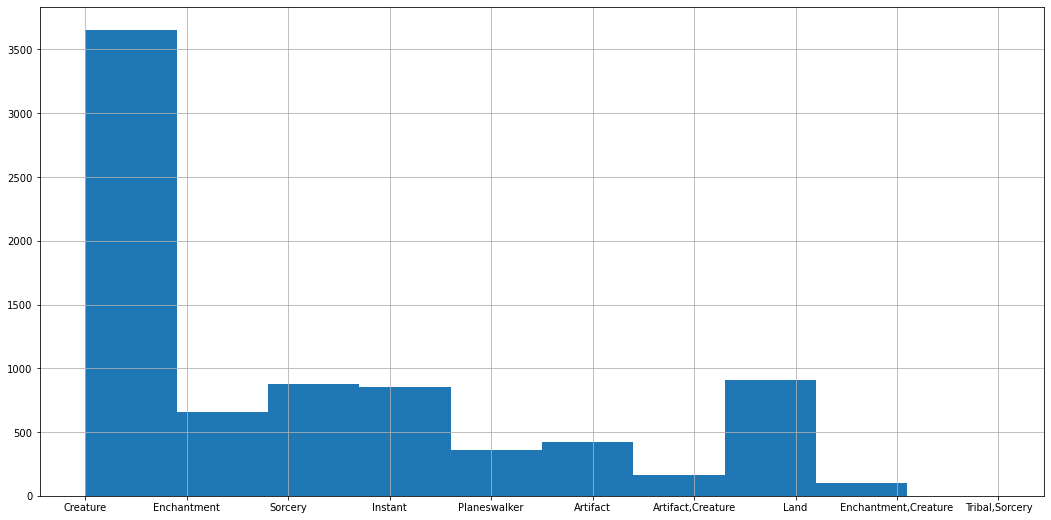

In [100]:
train_df.types.hist(
    bins=10,
    figsize=(18,9)
)

In [78]:
train_df\
    .groupby('cls', as_index=False)\
    .agg(cnt=('Names','count'))\
    .sort_values('cnt', ascending=False)\
    .describe()

,cnt
count,146.000000
mean,54.780822
std,135.028911
min,1.000000
25%,4.000000
50%,8.000000
75%,31.750000
max,905.000000


In [108]:
pw = 'Planeswalker'

In [114]:
train_df\
    .groupby('cls', as_index=False)\
    .agg(cnt=('Names','count'))\
    .sort_values('cnt', ascending=False)\
    .query("`cls`.str.contains('Planeswalker')")

,cls,cnt
115,U - Planeswalker,47
89,R - Planeswalker,44
59,G - Planeswalker,39
135,W - Planeswalker,33
11,B - Planeswalker,28
4,0 - Planeswalker,18
16,"B,G - Planeswalker",18
127,"U,W - Planeswalker",17
81,"G,W - Planeswalker",16
97,"R,U - Planeswalker",16


In [61]:
train_df.describe()

,Names,colors,manaCost,types,type,cls
count,7998,7998,7998,7998,7998,7998
unique,7998,36,333,10,796,146
top,Golgari_Findbroker-21112,0,0,Creature,Instant,0 - Land
freq,1,1391,907,3654,819,905


In [54]:
train_df.cls.value_counts()

0 - Land                      905
G - Creature                  658
W - Creature                  619
B - Creature                  600
R - Creature                  576
                             ... 
W - Artifact,Creature           1
G - Artifact,Creature           1
R,G - Sorcery                   1
R,U - Enchantment,Creature      1
U - Tribal,Sorcery              1
Name: cls, Length: 146, dtype: int64

In [22]:
for c in cards_df.sample(10).text:
    print(c+'\n')

Golgari Guildgate enters the battlefield tapped.
{T}: Add {B} or {G}.

{3}{G}: Gravel-Hide Goblin gets +2/+2 until end of turn.

Gain control of X target creatures and/or planeswalkers.

{X}{G}{G}: Put X +1/+1 counters on target land you control. That land becomes a 0/0 Elemental creature with haste. It's still a land.

Target creature gets +3/+3 until end of turn.

[+1]: Create a 1/1 white Kor Warrior creature token. You may attach an Equipment you control to it.
[−2]: Look at the top six cards of your library. You may reveal a Warrior or Equipment card from among them and put it into your hand. Put the rest on the bottom of your library in a random order.
[−3]: Nahiri, Heir of the Ancients deals damage to target creature or planeswalker equal to twice the number of Equipment you control.

When Gadwick, the Wizened enters the battlefield, draw X cards.
Whenever you cast a blue spell, tap target nonland permanent an opponent controls.

Flying
{R}: Skyship Stalker gets +1/+0 until end o

In [16]:
len(cards_txt)

7998

In [8]:
all_embeds = use_embed(cards_txt)
print(all_embeds.shape)

(7998, 512)


In [9]:
all_embeds.numpy().shape

(7998, 512)

In [47]:
np.save('all_embeds.npy', all_embeds)

In [10]:
all_embeds = np.load('all_embeds.npy')

In [11]:
all_embeds.shape

(7998, 512)

In [30]:
# Test Free Text Query
query = 'extra_turn'
embed_query = use_embed([query])
print(embed_query.shape)

(1, 512)


In [13]:
sim = np.inner(all_embeds, embed_query)
print(sim.shape)

(7998, 1)


In [31]:
sims_list = pd.DataFrame(sim, columns=['free_text_query'], index=cards_name)\
    .sort_values(by='free_text_query', ascending=False)\
    .head(50)\
    .reset_index()\
    .rename(columns={'index':'Names', 'free_text_query':'similarity'})\
    .merge(cards_df, how='left', on='Names')\
    .assign(similarity=lambda df: df.similarity.astype('str'))\
    .assign(id=lambda df: df.id.astype('str'))\
    .assign(mtgArenaId=lambda df: df.mtgArenaId.astype('str'))\
    .assign(loyalty=lambda df: df.loyalty.astype('str'))\
    .assign(power=lambda df: df.power.astype('str'))\
    .assign(toughness=lambda df: df.toughness.astype('str'))\
    .assign(convertedManaCost=lambda df: df.convertedManaCost.astype('str'))\
    .to_dict(orient='records')

sims_list[0]

{'Names': 'Time_Warp-17722',
 'similarity': '0.44100022',
 'id': '17722',
 'mtgArenaId': '0',
 'scryfallId': '87fe8637-9be1-4b57-832f-38cf92d23482',
 'name': 'Time Warp',
 'colors': 'U',
 'setName': 'Explorers of Ixalan',
 'convertedManaCost': '5.0',
 'manaCost': '{3}{U}{U}',
 'loyalty': '0',
 'power': '0',
 'toughness': '0',
 'type': 'Sorcery',
 'types': 'Sorcery',
 'subtypes': '0',
 'text': 'Target player takes an extra turn after this one.',
 'image_urls': "{'small': 'https://c1.scryfall.com/file/scryfall-cards/small/front/8/7/87fe8637-9be1-4b57-832f-38cf92d23482.jpg?1562927104', 'normal': 'https://c1.scryfall.com/file/scryfall-cards/normal/front/8/7/87fe8637-9be1-4b57-832f-38cf92d23482.jpg?1562927104', 'large': 'https://c1.scryfall.com/file/scryfall-cards/large/front/8/7/87fe8637-9be1-4b57-832f-38cf92d23482.jpg?1562927104', 'png': 'https://c1.scryfall.com/file/scryfall-cards/png/front/8/7/87fe8637-9be1-4b57-832f-38cf92d23482.png?1562927104', 'art_crop': 'https://c1.scryfall.com/fil

In [32]:
Item = {
    'freeText': query,
    'similarities': sims_list
}

In [11]:
merge_cols = [
    'Names','id','mtgArenaId','scryfallId','name','colors','setName',
    'convertedManaCost','manaCost','loyalty','power','toughness',
    'type','types','subtypes','text','image_urls',
    'brawl','commander','duel','future','historic','legacy','modern',
    'oldschool','pauper','penny','pioneer','standard','vintage'
]

cards_df = pd.read_csv('cards.csv')\
    .query('mtgArenaId.notnull()')\
    .assign(Names=lambda df: df.name + '-' + df.id.astype('str'))\
    .assign(Names=lambda df: df.Names.apply(lambda x: x.replace(' ', '_').replace('//', 'II')))\
    .fillna('0')\
    [merge_cols]

print(cards_df.shape)
cards_df.head(2)

(5419, 30)


,Names,id,mtgArenaId,scryfallId,name,colors,setName,convertedManaCost,manaCost,loyalty,...,future,historic,legacy,modern,oldschool,pauper,penny,pioneer,standard,vintage
4753,Archon_of_Sun's_Grace-4754,4754,74983.0,94f05268-0d4f-4638-aec3-a85fc339e3a7,Archon of Sun's Grace,W,Jumpstart Arena Exclusives,4.0,{2}{W}{W},0,...,Legal,Legal,Legal,Legal,Blank,Blank,Blank,Legal,Legal,Legal
4754,Audacious_Thief-4755,4755,74991.0,ba315deb-d5a9-4013-b6ef-e4efe652e569,Audacious Thief,B,Jumpstart Arena Exclusives,3.0,{2}{B},0,...,Blank,Legal,Legal,Legal,Blank,Legal,Blank,Legal,Blank,Legal


In [29]:
embed_df.columns.nunique()

5420

In [30]:
cards_df.query('Names == "Zof_Consumption_II_Zof_Bloodbog-55942"')

,Names,id,mtgArenaId,scryfallId,name,colors,setName,convertedManaCost,manaCost,loyalty,...,future,historic,legacy,modern,oldschool,pauper,penny,pioneer,standard,vintage
55941,Zof_Consumption_II_Zof_Bloodbog-55942,55942,73331.0,98496d5b-1519-4f0c-8b46-0a43be643dfb,Zof Consumption // Zof Bloodbog,B,Zendikar Rising,6.0,{4}{B}{B},0,...,Legal,Legal,Legal,Legal,Blank,Blank,Legal,Legal,Legal,Legal


In [362]:
all_cards = embed_df.columns

BATCH_SIZE = 100
batches = [list(all_cards[n:n+BATCH_SIZE]) for n in range(1, len(all_cards), BATCH_SIZE)]

In [21]:
merge_cols = [
    'Names','id','mtgArenaId','scryfallId','name','colors','setName',
    'convertedManaCost','manaCost','loyalty','power','toughness',
    'type','types','subtypes','text',
    'brawl','commander','duel','future','historic','legacy','modern',
    'oldschool','pauper','penny','pioneer','standard','vintage'
]

In [22]:
cards_df = pd.read_csv('cards.csv')\
    .query('mtgArenaId.notnull()')\
    .assign(Names=lambda df: df.name + '-' + df.id.astype('str'))\
    .assign(Names=lambda df: df.Names.apply(lambda x: x.replace(' ', '_').replace('//', 'II')))\
    .fillna('0')\
    [merge_cols]

print(cards_df.shape)
cards_df.head(3)

(5419, 29)


,Names,id,mtgArenaId,scryfallId,name,colors,setName,convertedManaCost,manaCost,loyalty,...,future,historic,legacy,modern,oldschool,pauper,penny,pioneer,standard,vintage
4753,Archon_of_Sun's_Grace-4754,4754,74983.0,94f05268-0d4f-4638-aec3-a85fc339e3a7,Archon of Sun's Grace,W,Jumpstart Arena Exclusives,4.0,{2}{W}{W},0,...,Legal,Legal,Legal,Legal,Blank,Blank,Blank,Legal,Legal,Legal
4754,Audacious_Thief-4755,4755,74991.0,ba315deb-d5a9-4013-b6ef-e4efe652e569,Audacious Thief,B,Jumpstart Arena Exclusives,3.0,{2}{B},0,...,Blank,Legal,Legal,Legal,Blank,Legal,Blank,Legal,Blank,Legal
4755,Banishing_Light-4756,4756,74986.0,ca112bae-6ac5-4cdf-9e8c-1b99f7396995,Banishing Light,W,Jumpstart Arena Exclusives,3.0,{2}{W},0,...,Legal,Legal,Legal,Legal,Blank,Blank,Legal,Legal,Legal,Legal


In [23]:
cards_df.Names.nunique()

5419

In [24]:
cards_df.name.nunique()

4267

In [25]:
cards_df.scryfallId.nunique()

5283

In [38]:
card = 'Oreskos_Swiftclaw-28847'

In [44]:
staged_card = embed_df[['Names', card]]\
    .merge(cards_df, how='left', on='Names')

Item = staged_card.query('Names == @card').to_dict(orient='records')

staged_card = staged_card\
    .sort_values(by=card, ascending=False)\
    .head(51)\
    .rename(columns={card: 'similarity'})\
    .assign(similarity=lambda df: df.similarity.astype('str'))\
    .assign(id=lambda df: df.id.astype('str'))\
    .assign(mtgArenaId=lambda df: df.mtgArenaId.astype('str'))\
    .assign(loyalty=lambda df: df.loyalty.astype('str'))\
    .assign(power=lambda df: df.power.astype('str'))\
    .assign(toughness=lambda df: df.toughness.astype('str'))\
    .assign(convertedManaCost=lambda df: df.convertedManaCost.astype('str'))

staged_card

,Names,similarity,id,mtgArenaId,scryfallId,name,colors,setName,convertedManaCost,manaCost,...,future,historic,legacy,modern,oldschool,pauper,penny,pioneer,standard,vintage
3884,Axebane_Beast-45872,0.9999998999999999,45872,69249.0,2f420b35-1f73-41c8-a15f-1aee4af0999c,Axebane Beast,G,Ravnica Allegiance,4.0,{3}{G},...,Blank,Legal,Legal,Legal,Blank,Legal,Legal,Legal,Blank,Legal
3684,Canal_Monitor-45672,0.9999998999999999,45672,66743.0,78226edc-87dd-4c38-987c-52aefe0f9531,Canal Monitor,B,Rivals of Ixalan,5.0,{4}{B},...,Blank,Legal,Legal,Legal,Blank,Legal,Legal,Legal,Blank,Legal
2901,Tolarian_Scholar-28942,0.9999998999999999,28942,67840.0,2eda67da-02b5-4ecb-9038-10e026d454ec,Tolarian Scholar,U,Core Set 2019,3.0,{2}{U},...,Blank,Legal,Legal,Legal,Blank,Legal,Legal,Legal,Blank,Legal
4864,Headwater_Sentries-54863,0.9999998999999999,54863,66077.0,2af2c338-f5e9-4596-9435-c6aa965ae541,Headwater Sentries,U,Ixalan,4.0,{3}{U},...,Blank,Legal,Legal,Legal,Blank,Legal,Legal,Legal,Blank,Legal
427,Armored_Whirl_Turtle-5931,0.9999998999999999,5931,75465.0,44a783f2-04d3-42fc-acc1-5f2974f9aca2,Armored Whirl Turtle,U,Arena Beginner Set,3.0,{2}{U},...,Blank,Legal,Legal,Blank,Blank,Legal,Blank,Blank,Blank,Legal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3598,Treetop_Warden-35145,0.9999998999999999,35145,69119.0,771341f5-11b2-4edc-aa41-088e852c058e,Treetop Warden,G,Arena New Player Experience Cards,2.0,{1}{G},...,Blank,Legal,Blank,Blank,Blank,Blank,Blank,Blank,Blank,Blank
4749,Rumbling_Baloth-54748,0.9999998999999999,54748,68801.0,a366fd5c-f6cd-4773-a25d-6114e11238cc,Rumbling Baloth,G,Arena New Player Experience Extras,4.0,{2}{G}{G},...,Blank,Legal,Legal,Legal,Blank,Legal,Legal,Legal,Blank,Legal
3053,Goblin_Assailant-29095,0.9999998999999999,29095,70114.0,8cfefb65-b6e4-44a1-baa9-d3c00ee8ba96,Goblin Assailant,R,Core Set 2020,2.0,{1}{R},...,Blank,Legal,Legal,Legal,Blank,Legal,Legal,Legal,Blank,Legal
786,Tolarian_Scholar-16832,0.9999998999999999,16832,67246.0,00d89839-60d7-4de2-a78a-1afdcc21c053,Tolarian Scholar,U,Dominaria,3.0,{2}{U},...,Blank,Legal,Legal,Legal,Blank,Legal,Legal,Legal,Blank,Legal


In [40]:
Item = staged_card.query('Names == @card').to_dict(orient='records')
Item

[{'Names': 'Oreskos_Swiftclaw-28847',
  'similarity': '0.9999998999999999',
  'id': '28847',
  'mtgArenaId': '67742.0',
  'scryfallId': '0ea1dfb4-1983-41f7-956c-f2a1d1489b54',
  'name': 'Oreskos Swiftclaw',
  'colors': 'W',
  'setName': 'Core Set 2019',
  'convertedManaCost': '2.0',
  'manaCost': '{1}{W}',
  'loyalty': '0',
  'power': '3',
  'toughness': '1',
  'type': 'Creature — Cat Warrior',
  'types': 'Creature',
  'subtypes': 'Cat,Warrior',
  'text': '0',
  'brawl': 'Blank',
  'commander': 'Legal',
  'duel': 'Legal',
  'future': 'Blank',
  'historic': 'Legal',
  'legacy': 'Legal',
  'modern': 'Legal',
  'oldschool': 'Blank',
  'pauper': 'Legal',
  'penny': 'Legal',
  'pioneer': 'Legal',
  'standard': 'Blank',
  'vintage': 'Legal'}]

## Get card item from Dyanmo

In [1]:
import os
import json
import boto3
from boto3.dynamodb.conditions import Key

In [2]:
SIMILARITY_TABLE = 'similarity-dev'

In [3]:
boto_sess = boto3.Session(profile_name='lw2134')
dynamodb = boto_sess.resource('dynamodb')
table = dynamodb.Table(SIMILARITY_TABLE)

In [8]:
# QUERY CARD BY NAME CONTAINS
card_item = table.query(
    KeyConditions={
        'name': {
            'AttributeValueList': ['Banishing'],
            'ComparisonOperator': 'BEGINS_WITH'
        }
    }
)

print(card_item)
#print(card_item['Items'][0]['name'])
#print(len(card_item['Items']))
#print(card_item['Items'][0]['text'])

ClientError: An error occurred (ValidationException) when calling the Query operation: Query key condition not supported

In [323]:
# QUERY BY NAME
card_item = table.query(
    KeyConditionExpression=Key('name').eq("Bontu's Last Reckoning")
)

print(card_item['Items'][0]['name'])
print(len(card_item['Items']))
print(card_item['Items'][0]['text'])

Bontu's Last Reckoning
1
Destroy all creatures. Lands you control don't untap during your next untap step.


## Call deployed API

In [10]:
import requests

### Scryfall Card Search API

In [23]:
q = 'garruk cursed'

In [24]:
res = requests.get('https://api.scryfall.com/cards/search?q={}'.format(q))

In [25]:
res.json()

{'object': 'list',
 'total_cards': 2,
 'has_more': False,
 'data': [{'object': 'card',
   'id': 'abef512f-8f1d-4257-b16f-c0eed58670ec',
   'oracle_id': 'e0cef79c-ad47-4cbc-9d73-a913e487ccb7',
   'multiverse_ids': [473153],
   'mtgo_id': 78526,
   'arena_id': 70338,
   'tcgplayer_id': 198500,
   'cardmarket_id': 398939,
   'name': 'Garruk, Cursed Huntsman',
   'lang': 'en',
   'released_at': '2019-10-04',
   'uri': 'https://api.scryfall.com/cards/abef512f-8f1d-4257-b16f-c0eed58670ec',
   'scryfall_uri': 'https://scryfall.com/card/eld/191/garruk-cursed-huntsman?utm_source=api',
   'layout': 'normal',
   'highres_image': True,
   'image_uris': {'small': 'https://c1.scryfall.com/file/scryfall-cards/small/front/a/b/abef512f-8f1d-4257-b16f-c0eed58670ec.jpg?1572490758',
    'normal': 'https://c1.scryfall.com/file/scryfall-cards/normal/front/a/b/abef512f-8f1d-4257-b16f-c0eed58670ec.jpg?1572490758',
    'large': 'https://c1.scryfall.com/file/scryfall-cards/large/front/a/b/abef512f-8f1d-4257-b16

### MagicML Semantic Search API

In [390]:
query = {
  "key": "name",
  "value": "Murder"
}

In [393]:
res = requests.post('https://38axjswipg.execute-api.us-east-1.amazonaws.com/dev/query', json=query)

if len(res.json()['cards']) > 0:
    print(res.json()['cards'][0]['Names'])
    print(res.json()['cards'][0]['name'])
    print(len(res.json()['cards']))
else:
    print(res.json()['cards'])

Murder-29173
Murder
1


In [394]:
res.json()

{'cards': [{'subtypes': '0',
   'setName': 'Core Set 2020',
   'duel': 'Legal',
   'mtgArenaId': '69894.0',
   'scryfallId': '6a2b22bc-e81b-4f27-a52b-9f3edad25439',
   'types': 'Instant',
   'brawl': 'Blank',
   'name': 'Murder',
   'penny': 'Legal',
   'pioneer': 'Legal',
   'convertedManaCost': '3.0',
   'modern': 'Legal',
   'colors': 'B',
   'id': '29173',
   'future': 'Blank',
   'historic': 'Legal',
   'commander': 'Legal',
   'toughness': '0',
   'loyalty': '0',
   'pauper': 'Legal',
   'Names': 'Murder-29173',
   'text': 'Destroy target creature.',
   'image_urls': "{'small': 'https://c1.scryfall.com/file/scryfall-cards/small/front/6/a/6a2b22bc-e81b-4f27-a52b-9f3edad25439.jpg?1592516737', 'normal': 'https://c1.scryfall.com/file/scryfall-cards/normal/front/6/a/6a2b22bc-e81b-4f27-a52b-9f3edad25439.jpg?1592516737', 'large': 'https://c1.scryfall.com/file/scryfall-cards/large/front/6/a/6a2b22bc-e81b-4f27-a52b-9f3edad25439.jpg?1592516737', 'png': 'https://c1.scryfall.com/file/scryfal

## Lambda Cards Sorter Master

In [39]:
STAGE = 'dev'

In [40]:
_, s3, boto_sess = aws_connect('s3', 'lw2134', session=True)
lambda_client = boto_sess.client('lambda')

In [41]:
all_cards = pred_df.columns

In [47]:
BATCHES_OF = 10
batches = [list(all_cards[n:n+BATCHES_OF]) for n in range(1, len(all_cards), BATCHES_OF)]
print(len(batches))
batches[0]

542


["Archon_of_Sun's_Grace-AJMP",
 'Audacious_Thief-AJMP',
 'Banishing_Light-AJMP',
 'Bond_of_Revival-AJMP',
 'Carnifex_Demon-AJMP',
 'Doomed_Necromancer-AJMP',
 'Dryad_Greenseeker-AJMP',
 'Fanatic_of_Mogis-AJMP',
 'Gadwick,_the_Wizened-AJMP',
 'Goblin_Oriflamme-AJMP']

In [49]:
import json

In [54]:
json.dumps(batches[0][0:5])

'["Archon_of_Sun\'s_Grace-AJMP", "Audacious_Thief-AJMP", "Banishing_Light-AJMP", "Bond_of_Revival-AJMP", "Carnifex_Demon-AJMP"]'

In [141]:
for cards in batches:
    payload = {'cards': cards}

    res = lambda_client.invoke(
        FunctionName='magicml-similarity-{}-stage_embed_worker'.format(STAGE),
        InvocationType='Event',
        Payload=json.dumps(payload)
    )

In [142]:
a_card = pd.read_csv('sorted/Banishing_Light-AJMP.csv')
print(a_card.shape)

(7639, 33)


In [149]:
a_card.head(3)

,Banishing_Light-AJMP,id,mtgArenaId,scryfallId,name,colorIdentity,colors,setName,convertedManaCost,manaCost,...,future,historic,legacy,modern,oldschool,pauper,penny,pioneer,standard,vintage
0,1.000000,4756,74986.0,ca112bae-6ac5-4cdf-9e8c-1b99f7396995,Banishing Light,W,W,Jumpstart Arena Exclusives,3.0,{2}{W},...,Legal,Legal,Legal,Legal,Blank,Blank,Legal,Legal,Legal,Legal
1,1.000000,49136,70515.0,a1ddd113-140f-49c9-b45c-cf1b0d1dffd8,Banishing Light,W,W,Theros Beyond Death,3.0,{2}{W},...,Legal,Legal,Legal,Legal,Blank,Blank,Legal,Legal,Legal,Legal
2,0.773027,28775,67708.0,197743cd-249c-42ba-ac8d-027c088f8418,Hieromancer's Cage,W,W,Core Set 2019,4.0,{3}{W},...,Blank,Legal,Legal,Legal,Blank,Blank,Blank,Legal,Blank,Legal
